# Algorithm Performance Assessment

Self standing Python code and results within Jupyter Book

## L1 E2ES Demonstration Reference Scenario (Picasso) scene definition

```{figure} ./figures/picasso-scene.png
--- 
name: picasso-scene
width: 500px
---
Demonstration Reference Scenario (Picasso) including a radiometric scene (left) representing 8 different surface types (2x sea ice, 2x land, 4x ocean) adjacent to each other and sea ice concentration sub-resolution gradients, and a geometric scene (right) with a high-contrast brightness temperature pattern.
```

## Algorithm Performance Metrics (MPEF)

The performance of the TSA algorithm is evaluated by means of classification accuracy.
For this, TSA estimates are divided into true positive (TP), false positive (FP), true negative (TN) and false negative (FN) observations.
Those observation classes for a single day are used to calculate the daily classification accuracy:

```{math}
:label: accuracy
\text{accuracy} = \frac{\text{TP}+\text{TN}}{\text{TP}+\text{FP}+\text{TN}+\text{FN}},
```

which is obtained for all days and subsequently used to derive monthly and total mean accuracy values.
In addition, observation classes are binned with respect to corresponding in situ SD which clarifies the ability of the TSA algorithm to detect dry snow for varying snow depth.

## Algorithm Calibration Data Set (ACDAT)

N/a

## Algorithm Validation Data Set (AVDAT)

The reference dataset spans the years 2017 and 2018, thus covering a whole snow season in the Northern Hemisphere.
It follows closely the structure of existing ESA CCI reference datasets for other climate variables, commonly in the form of a Multisensor Matchup Dataset (MMD).
Brightness temperatures for all CIMR equivalent channels are obtained from AMSR2 and SMAP data products, such as the AMSR2 level 1R (L1R) swath data product.
The inclusion of all channels, in addition to Ka and Ku as main bands for TSA retrieval, aims to facilitate further research on the development and tuning of the TSA algorithm.
Main sources for in situ snow depth measurements are the European Centre for Medium-Range Weather Forecasts (ECMWF) and the Global Historical Climatology Network {cite:p}`menne_2012`.
Those are complemented by observations of the World Data Center of the All-Russia Research Institute of Hydrometeorological Information {cite:p}`bulygina_2012`, of the Meteorological Service of Canada, and from across the continental United States {cite:p}`dyer_mote_2006`.
The observations encompass both snow and snow-free conditions.
Quality control of the weather station data includes, but is not limited to, filtering for duplicates, as well as for negative and extremely high SD values.
In situ data from the same sources though with different filtering applied, were used e.g. by {cite:t}`luojus_2021`.

## Test Results using Demonstration Reference Scenario

Imports, input data and grid definition for later reprojection to EASE-Grid 2.0 (Northern Hemisphere):

In [1]:
import os
import xarray as xr
import numpy as np
import pandas as pd
import pyresample as pr
from scipy import spatial
import matplotlib.image
from matplotlib import pyplot as plt
from matplotlib import colors
import datetime as dt
import cartopy
from cartopy import crs as ccrs, feature as cfeature

In [2]:
l1x_geo = '../data/W_PT-DME-Lisbon-SAT-CIMR-1X@KA_C_DME_20230417T105425_LD_20280110T114800_20280110T115700_TN.nc'
FWD_geolocation_geo = xr.open_dataset(l1x_geo, group='FWD_geolocation')
BCK_geolocation_geo = xr.open_dataset(l1x_geo, group='BCK_geolocation')
data_fwd_geo = dict()
data_bck_geo = dict()

l1x_rad = '../data/W_PT-DME-Lisbon-SAT-CIMR-1X@KA_C_DME_20230420T103323_LD_20280110T114800_20280110T115700_TN.nc'
FWD_geolocation_rad = xr.open_dataset(l1x_rad, group='FWD_geolocation')
BCK_geolocation_rad = xr.open_dataset(l1x_rad, group='BCK_geolocation')
data_fwd_rad = dict()
data_bck_rad = dict()

bands = ('L', 'C', 'X', 'KU', 'KA')
for gr in bands:
    data_fwd_geo[gr] = xr.open_dataset(l1x_geo, group='FWD_' + gr + '_BAND')
    data_bck_geo[gr] = xr.open_dataset(l1x_geo, group='BCK_' + gr + '_BAND')
    data_fwd_rad[gr] = xr.open_dataset(l1x_rad, group='FWD_' + gr + '_BAND')
    data_bck_rad[gr] = xr.open_dataset(l1x_rad, group='BCK_' + gr + '_BAND')

In [3]:
fname = '../data/auxiliary/NSIDC0772_LatLon_EASE2_N12.5km_v1.0.nc'
#fname = '../data/auxiliary/NSIDC0772_LatLon_EASE2_N6.25km_v1.0.nc')
#fname = '../data/auxiliary/NSIDC0772_LatLon_EASE2_N3.125km_v1.0.nc')

mask_latlon = xr.open_dataset(fname)
lat = mask_latlon['latitude'].values
lon = mask_latlon['longitude'].values

# 1 = 12.5 km, 2 = 6.25 km, 4 = 3.125 km
grid = 1
area_id = 'ease2_nh'
description = 'EASE-Grid 2.0 Northern Hemisphere (12.5 km)'
proj_id = 'ease2_nh'
projection = 'EPSG:6931'
width = 1440*grid
height = 1440*grid
area_extent = (-9000000.0, -9000000.0, 9000000.0, 9000000.0)
area_def = pr.geometry.AreaDefinition(area_id, description, proj_id, projection,
                          width, height, area_extent)
radius_of_influence = 20000/grid

### Radiometric Scene

In [4]:
data_fwd = data_fwd_rad
data_bck = data_bck_rad
geolocation_fwd = FWD_geolocation_rad
geolocation_bck = BCK_geolocation_rad

Main dry snow detection algorithm:

In [5]:
sd_fwd = 15.9 * (data_fwd['KU'].brightness_temperature_h - data_fwd['KA'].brightness_temperature_h)
sd_bck = 15.9 * (data_bck['KU'].brightness_temperature_h - data_bck['KA'].brightness_temperature_h)

shp_fwd = tuple(data_fwd['KA'].dims[d] for d in ['n_scans_interleave_feed', 'n_samples_earth'])
shp_bck = tuple(data_bck['KA'].dims[d] for d in ['n_scans_interleave_feed', 'n_samples_earth'])

TSA_fwd = np.zeros(shp_fwd)
TSA_fwd[(sd_fwd > 30) & (data_fwd['KA'].brightness_temperature_v < 255) & (data_fwd['KA'].brightness_temperature_h < 250)] = 1

TSA_bck = np.zeros(shp_bck)
TSA_bck[(sd_bck > 30) & (data_bck['KA'].brightness_temperature_v < 255) & (data_bck['KA'].brightness_temperature_h < 250)] = 1

Supporting dry snow detection algorithms: 

In [6]:
Ta_19h = data_fwd['KU'].brightness_temperature_h - 7
Ta_19v = data_fwd['KU'].brightness_temperature_v - 7
Ta_36v = data_fwd['KA'].brightness_temperature_v - 4

scattering = np.zeros(shp_fwd)
scattering[((Ta_19v-Ta_36v) > 0)] = 1
precipitation = np.zeros(shp_fwd)
precipitation[((Ta_19v-Ta_36v) <= 2)] = 1
colddesert = np.zeros(shp_fwd)
colddesert[((Ta_19v-Ta_19h) >= 18) & ((Ta_19v-Ta_36v) <= 10)] = 1
frozenground = np.zeros(shp_fwd)
frozenground[((Ta_19v-Ta_19h) >= 8) & ((Ta_19v-Ta_36v) <= 2)] = 1
    
TSA_fwd_2 = np.zeros(shp_fwd)
TSA_fwd_2[(scattering == 1) & (precipitation == 0) & (colddesert == 0) & (frozenground == 0)] = 1

Ta_19h = data_bck['KU'].brightness_temperature_h - 7
Ta_19v = data_bck['KU'].brightness_temperature_v - 7
Ta_36v = data_bck['KA'].brightness_temperature_v - 4

scattering = np.zeros(shp_bck)
scattering[((Ta_19v-Ta_36v) > 0)] = 1
precipitation = np.zeros(shp_bck)
precipitation[((Ta_19v-Ta_36v) <= 2)] = 1
colddesert = np.zeros(shp_bck)
colddesert[((Ta_19v-Ta_19h) >= 18) & ((Ta_19v-Ta_36v) <= 10)] = 1
frozenground = np.zeros(shp_bck)
frozenground[((Ta_19v-Ta_19h) >= 8) & ((Ta_19v-Ta_36v) <= 2)] = 1

TSA_bck_2 = np.zeros(shp_bck)
TSA_bck_2[(scattering == 1) & (precipitation == 0) & (colddesert == 0) & (frozenground == 0)] = 1

##

TSA_fwd_3 = np.zeros(shp_fwd)
TSA_fwd_3[(data_fwd['KA'].brightness_temperature_h < 245) & (data_fwd['KA'].brightness_temperature_v < 255)] = 1

TSA_fwd_3[(TSA_fwd_3 == 1) & ((data_fwd['X'].brightness_temperature_v - data_fwd['KA'].brightness_temperature_v <= 0) | (data_fwd['X'].brightness_temperature_h - data_fwd['KA'].brightness_temperature_h <= 0))] = 0

TSA_bck_3 = np.zeros(shp_bck)
TSA_bck_3[(data_bck['KA'].brightness_temperature_h < 245) & (data_bck['KA'].brightness_temperature_v < 255)] = 1

TSA_bck_3[(TSA_bck_3 == 1) & ((data_bck['X'].brightness_temperature_v - data_bck['KA'].brightness_temperature_v <= 0) | (data_bck['X'].brightness_temperature_h - data_bck['KA'].brightness_temperature_h <= 0))] = 0

Individual quality assessment (QA) for forward (FWD) and backward (BCK) scans using all algorithms:

In [7]:
qa_fwd = np.zeros(shp_fwd)

qa_fwd[TSA_fwd == 1] = 1
qa_fwd[(TSA_fwd == 1) & ((TSA_fwd_2 == 1) | (TSA_fwd_3 == 1))] = 2
qa_fwd[(TSA_fwd == 1) & (TSA_fwd_2 == 1) & (TSA_fwd_3 == 1)] = 3

qa_bck = np.zeros(shp_bck)

qa_bck[TSA_bck == 1] = 1
qa_bck[(TSA_bck == 1) & ((TSA_bck_2 == 1) | (TSA_bck_3 == 1))] = 2
qa_bck[(TSA_bck == 1) & (TSA_bck_2 == 1) & (TSA_bck_3 == 1)] = 3

Once the main algorithm detects snow, a cell is flagged as such. Detected snow is divided into three quality or confidence classes: fair, good and very good. Those represent snow detected by the main algorithm only, by the main and one additional algorithm, and by all three algorithms, respectively.

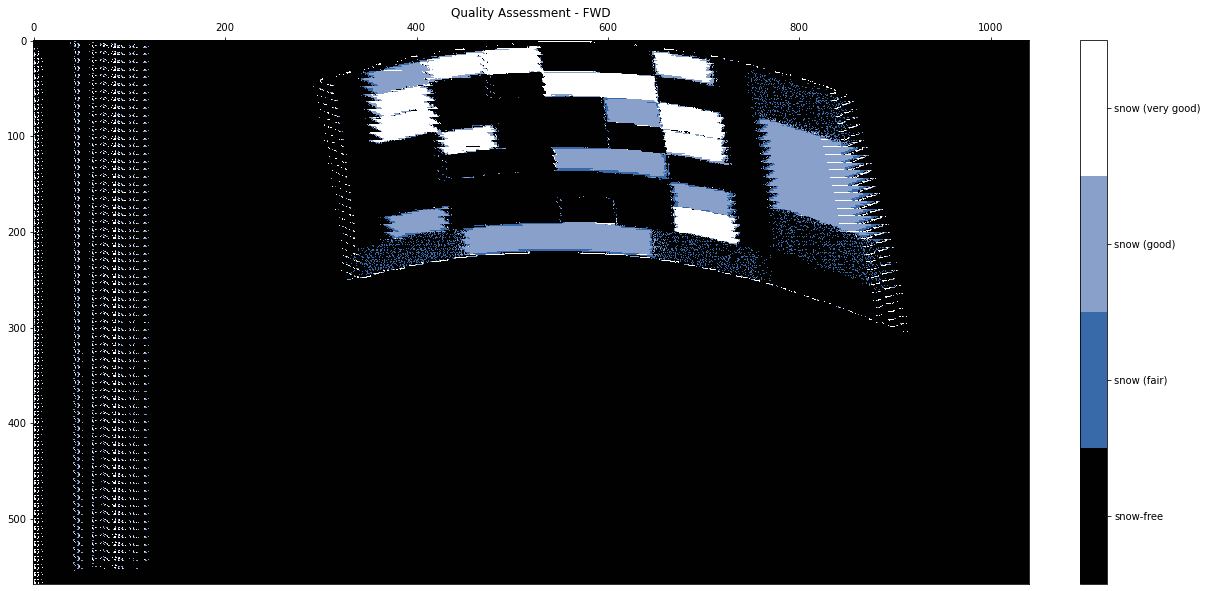

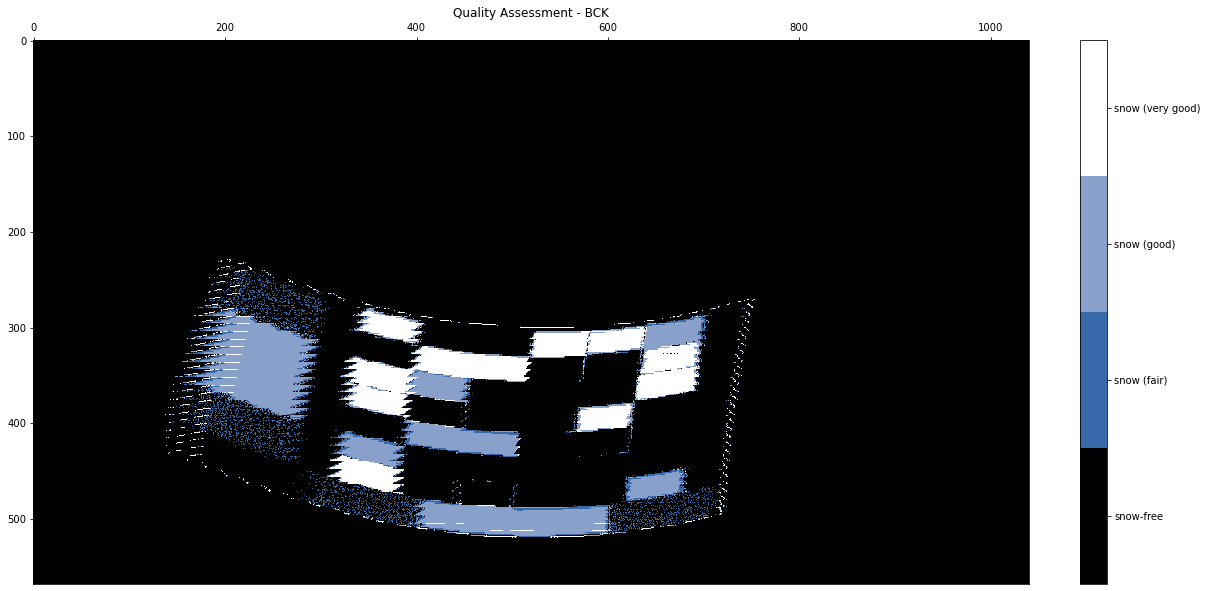

In [8]:
map = colors.ListedColormap(['#010101', '#3869A8', '#89A0CA', '#FFFFFF'])
bounds=[-0.5,0.5,1.5,2.5,3.5]

fig, ax = plt.subplots(figsize=(20,10))
plt.imshow(qa_fwd, interpolation='nearest', cmap=map)
cbar = plt.colorbar(boundaries=bounds, ticks=[0, 1, 2, 3], fraction=0.031, pad=0.046)
cbar.ax.set_yticklabels(['snow-free', 'snow (fair)', 'snow (good)', 'snow (very good)'])
ax.xaxis.tick_top()
ax.set_title('Quality Assessment - FWD')
plt.show()

fig, ax = plt.subplots(figsize=(20,10))
plt.imshow(qa_bck, interpolation='nearest', cmap=map)
cbar = plt.colorbar(boundaries=bounds, ticks=[0, 1, 2, 3], fraction=0.031, pad=0.046)
cbar.ax.set_yticklabels(['snow-free', 'snow (fair)', 'snow (good)', 'snow (very good)'])
ax.xaxis.tick_top()
ax.set_title('Quality Assessment - BCK')
plt.show()

Reprojection to EASE-Grid 2.0 Northern Hemisphere and combined quality assessment:

In [9]:
# FWD
lons = geolocation_fwd['lon'].values
lats = geolocation_fwd['lat'].values
qa = qa_fwd

swath_def = pr.geometry.SwathDefinition(lons=lons, lats=lats)
TSA_QA_ease_fwd = pr.kd_tree.resample_nearest(swath_def, qa, area_def,
                          radius_of_influence=radius_of_influence, fill_value=np.nan)

# BCK
lons = geolocation_bck['lon'].values
lats = geolocation_bck['lat'].values
qa = qa_bck

swath_def = pr.geometry.SwathDefinition(lons=lons, lats=lats)
TSA_QA_ease_bck = pr.kd_tree.resample_nearest(swath_def, qa, area_def,
                          radius_of_influence=radius_of_influence, fill_value=np.nan)

# QA
id_fwd = np.isnan(TSA_QA_ease_fwd)
id_bck = np.isnan(TSA_QA_ease_bck)
keep_fwd = ~id_fwd & id_bck
keep_bck = id_fwd & ~id_bck
TSA_QA_ease = TSA_QA_ease_fwd + TSA_QA_ease_bck
TSA_QA_ease[keep_fwd] = TSA_QA_ease_fwd[keep_fwd]
TSA_QA_ease[keep_bck] = TSA_QA_ease_bck[keep_bck]

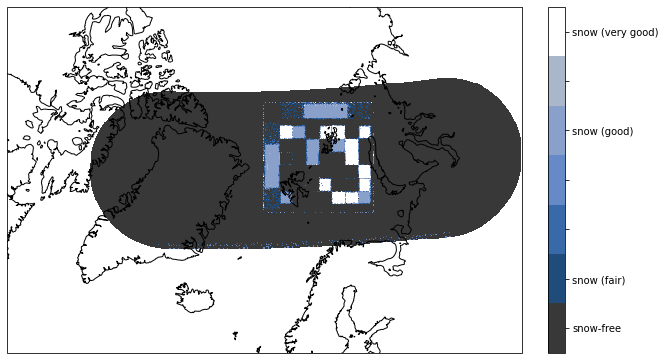

In [10]:
map = colors.ListedColormap(['#383838', '#1F4C7B', '#3869A8', '#658AC7', '#89A0CA', '#AAB6CA', '#FFFFFF'])
bounds=[-0.5,0.5,1.5,2.5,3.5,4.5,5.5,6.5]
norm = colors.BoundaryNorm(bounds, map.N)

ax = plt.axes(projection=ccrs.LambertAzimuthalEqualArea(central_latitude=+90.0))
img = ax.pcolormesh(lon[600*grid:900*grid,500*grid:1000*grid], lat[600*grid:900*grid,500*grid:1000*grid], TSA_QA_ease[600*grid:900*grid,500*grid:1000*grid], shading='nearest', transform=ccrs.PlateCarree(), cmap=map)
cbar = plt.colorbar(img, cmap=map, norm=norm, boundaries=bounds, ticks=[0,1,2,3,4,5,6], fraction=0.031, pad=0.046)
cbar.ax.set_yticklabels(['snow-free', 'snow (fair)', '', '', 'snow (good)', '', 'snow (very good)'])
ax.coastlines()
ax.set_extent([-110, 110, 60, 90,], crs=ccrs.PlateCarree())
plt.gcf().set_size_inches((10,10))
plt.show()

### Geometric Scene

In [11]:
data_fwd = data_fwd_geo
data_bck = data_bck_geo
geolocation_fwd = FWD_geolocation_geo
geolocation_bck = BCK_geolocation_geo

Apart from selecting the geometric scene as input data, the processing is analogous to the radiometric scene including the main and supporting dry snow detection algorithms as well as the individual FWD/BCK QA, reprojection to EASE-Grid 2.0 (NH) and the combined QA.

In [12]:
sd_fwd = 15.9 * (data_fwd['KU'].brightness_temperature_h - data_fwd['KA'].brightness_temperature_h)
sd_bck = 15.9 * (data_bck['KU'].brightness_temperature_h - data_bck['KA'].brightness_temperature_h)

shp_fwd = tuple(data_fwd['KA'].dims[d] for d in ['n_scans_interleave_feed', 'n_samples_earth'])
shp_bck = tuple(data_bck['KA'].dims[d] for d in ['n_scans_interleave_feed', 'n_samples_earth'])

TSA_fwd = np.zeros(shp_fwd)
TSA_fwd[(sd_fwd > 30) & (data_fwd['KA'].brightness_temperature_v < 255) & (data_fwd['KA'].brightness_temperature_h < 250)] = 1

TSA_bck = np.zeros(shp_bck)
TSA_bck[(sd_bck > 30) & (data_bck['KA'].brightness_temperature_v < 255) & (data_bck['KA'].brightness_temperature_h < 250)] = 1

##

Ta_19h = data_fwd['KU'].brightness_temperature_h - 7
Ta_19v = data_fwd['KU'].brightness_temperature_v - 7
Ta_36v = data_fwd['KA'].brightness_temperature_v - 4

scattering = np.zeros(shp_fwd)
scattering[((Ta_19v-Ta_36v) > 0)] = 1
precipitation = np.zeros(shp_fwd)
precipitation[((Ta_19v-Ta_36v) <= 2)] = 1
colddesert = np.zeros(shp_fwd)
colddesert[((Ta_19v-Ta_19h) >= 18) & ((Ta_19v-Ta_36v) <= 10)] = 1
frozenground = np.zeros(shp_fwd)
frozenground[((Ta_19v-Ta_19h) >= 8) & ((Ta_19v-Ta_36v) <= 2)] = 1
    
TSA_fwd_2 = np.zeros(shp_fwd)
TSA_fwd_2[(scattering == 1) & (precipitation == 0) & (colddesert == 0) & (frozenground == 0)] = 1

Ta_19h = data_bck['KU'].brightness_temperature_h - 7
Ta_19v = data_bck['KU'].brightness_temperature_v - 7
Ta_36v = data_bck['KA'].brightness_temperature_v - 4

scattering = np.zeros(shp_bck)
scattering[((Ta_19v-Ta_36v) > 0)] = 1
precipitation = np.zeros(shp_bck)
precipitation[((Ta_19v-Ta_36v) <= 2)] = 1
colddesert = np.zeros(shp_bck)
colddesert[((Ta_19v-Ta_19h) >= 18) & ((Ta_19v-Ta_36v) <= 10)] = 1
frozenground = np.zeros(shp_bck)
frozenground[((Ta_19v-Ta_19h) >= 8) & ((Ta_19v-Ta_36v) <= 2)] = 1

TSA_bck_2 = np.zeros(shp_bck)
TSA_bck_2[(scattering == 1) & (precipitation == 0) & (colddesert == 0) & (frozenground == 0)] = 1

##

TSA_fwd_3 = np.zeros(shp_fwd)
TSA_fwd_3[(data_fwd['KA'].brightness_temperature_h < 245) & (data_fwd['KA'].brightness_temperature_v < 255)] = 1

TSA_fwd_3[(TSA_fwd_3 == 1) & ((data_fwd['X'].brightness_temperature_v - data_fwd['KA'].brightness_temperature_v <= 0) | (data_fwd['X'].brightness_temperature_h - data_fwd['KA'].brightness_temperature_h <= 0))] = 0

TSA_bck_3 = np.zeros(shp_bck)
TSA_bck_3[(data_bck['KA'].brightness_temperature_h < 245) & (data_bck['KA'].brightness_temperature_v < 255)] = 1

TSA_bck_3[(TSA_bck_3 == 1) & ((data_bck['X'].brightness_temperature_v - data_bck['KA'].brightness_temperature_v <= 0) | (data_bck['X'].brightness_temperature_h - data_bck['KA'].brightness_temperature_h <= 0))] = 0

In [13]:
qa_fwd = np.zeros(shp_fwd)

qa_fwd[TSA_fwd == 1] = 1
qa_fwd[(TSA_fwd == 1) & ((TSA_fwd_2 == 1) | (TSA_fwd_3 == 1))] = 2
qa_fwd[(TSA_fwd == 1) & (TSA_fwd_2 == 1) & (TSA_fwd_3 == 1)] = 3

qa_bck = np.zeros(shp_bck)

qa_bck[TSA_bck == 1] = 1
qa_bck[(TSA_bck == 1) & ((TSA_bck_2 == 1) | (TSA_bck_3 == 1))] = 2
qa_bck[(TSA_bck == 1) & (TSA_bck_2 == 1) & (TSA_bck_3 == 1)] = 3

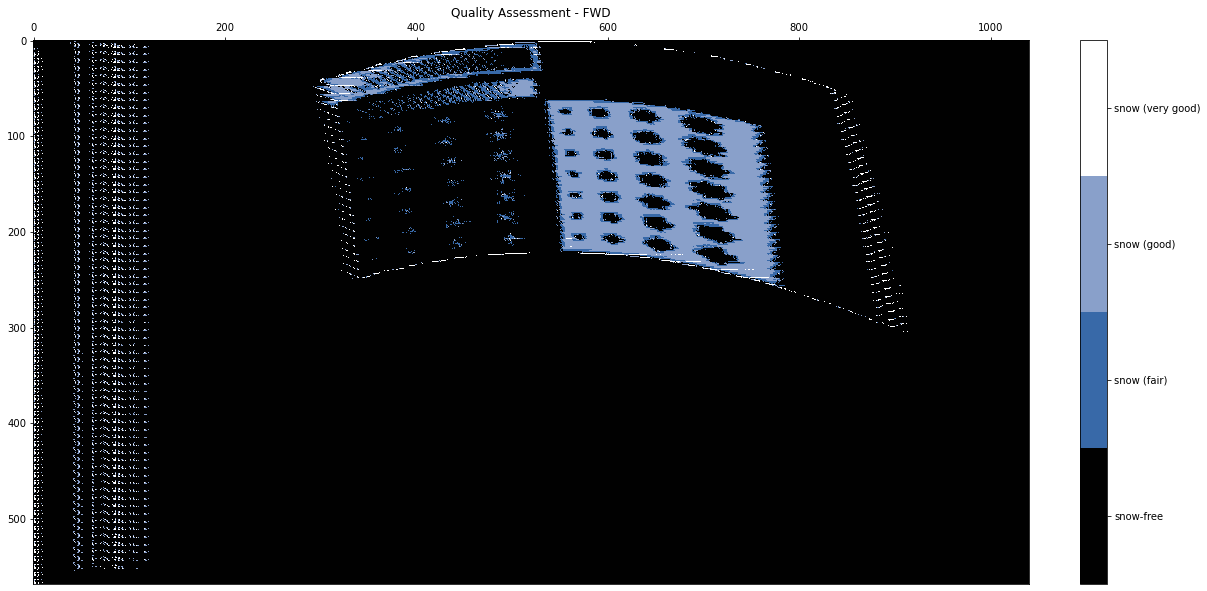

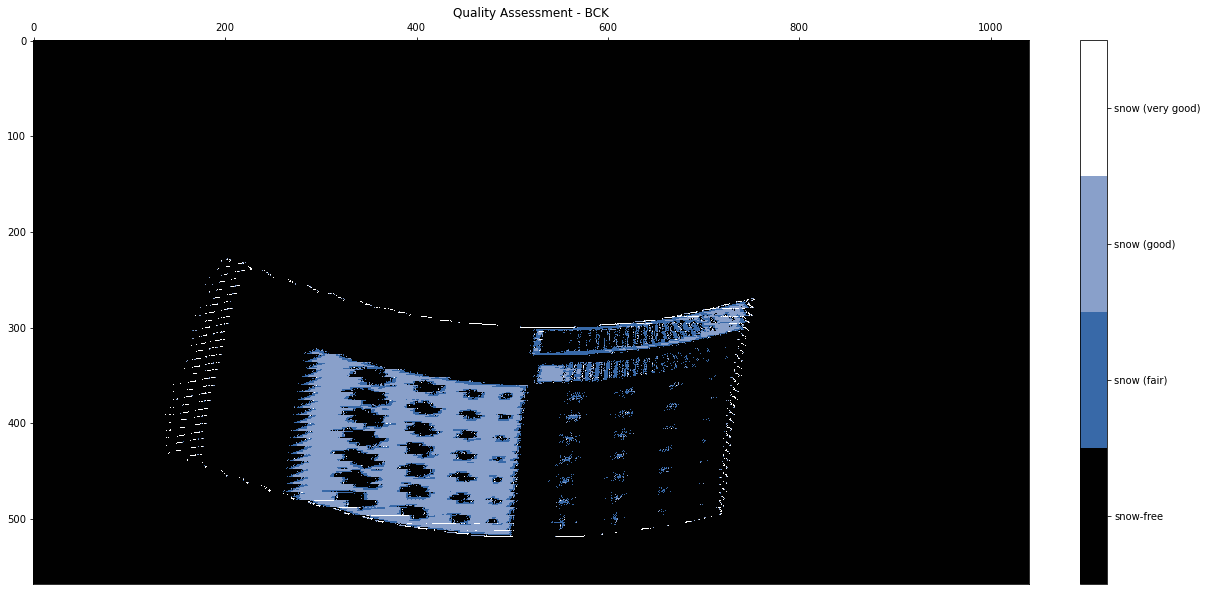

In [14]:
map = colors.ListedColormap(['#010101', '#3869A8', '#89A0CA', '#FFFFFF'])
bounds=[-0.5,0.5,1.5,2.5,3.5]

fig, ax = plt.subplots(figsize=(20,10))
plt.imshow(qa_fwd, interpolation='nearest', cmap=map)
cbar = plt.colorbar(boundaries=bounds, ticks=[0, 1, 2, 3], fraction=0.031, pad=0.046)
cbar.ax.set_yticklabels(['snow-free', 'snow (fair)', 'snow (good)', 'snow (very good)'])
ax.xaxis.tick_top()
ax.set_title('Quality Assessment - FWD')
plt.show()

fig, ax = plt.subplots(figsize=(20,10))
plt.imshow(qa_bck, interpolation='nearest', cmap=map)
cbar = plt.colorbar(boundaries=bounds, ticks=[0, 1, 2, 3], fraction=0.031, pad=0.046)
cbar.ax.set_yticklabels(['snow-free', 'snow (fair)', 'snow (good)', 'snow (very good)'])
ax.xaxis.tick_top()
ax.set_title('Quality Assessment - BCK')
plt.show()

In [15]:
# FWD
lons = geolocation_fwd['lon'].values
lats = geolocation_fwd['lat'].values
qa = qa_fwd

swath_def = pr.geometry.SwathDefinition(lons=lons, lats=lats)
TSA_QA_ease_fwd = pr.kd_tree.resample_nearest(swath_def, qa, area_def,
                          radius_of_influence=radius_of_influence, fill_value=np.nan)

# BCK
lons = geolocation_bck['lon'].values
lats = geolocation_bck['lat'].values
qa = qa_bck

swath_def = pr.geometry.SwathDefinition(lons=lons, lats=lats)
TSA_QA_ease_bck = pr.kd_tree.resample_nearest(swath_def, qa, area_def,
                          radius_of_influence=radius_of_influence, fill_value=np.nan)

# QA
id_fwd = np.isnan(TSA_QA_ease_fwd)
id_bck = np.isnan(TSA_QA_ease_bck)
keep_fwd = ~id_fwd & id_bck
keep_bck = id_fwd & ~id_bck
TSA_QA_ease = TSA_QA_ease_fwd + TSA_QA_ease_bck
TSA_QA_ease[keep_fwd] = TSA_QA_ease_fwd[keep_fwd]
TSA_QA_ease[keep_bck] = TSA_QA_ease_bck[keep_bck]

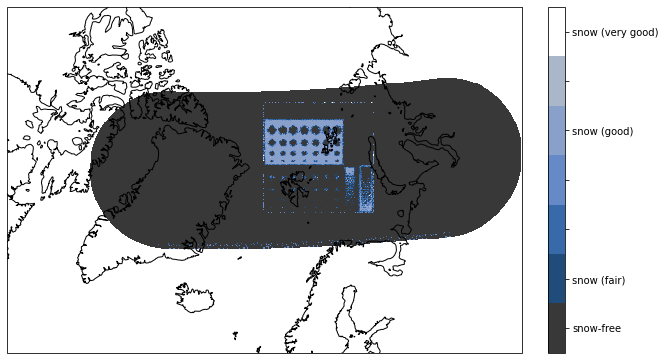

In [16]:
map = colors.ListedColormap(['#383838', '#1F4C7B', '#3869A8', '#658AC7', '#89A0CA', '#AAB6CA', '#FFFFFF'])
bounds=[-0.5,0.5,1.5,2.5,3.5,4.5,5.5,6.5]
norm = colors.BoundaryNorm(bounds, map.N)

ax = plt.axes(projection=ccrs.LambertAzimuthalEqualArea(central_latitude=+90.0))
img = ax.pcolormesh(lon[600*grid:900*grid,500*grid:1000*grid], lat[600*grid:900*grid,500*grid:1000*grid], TSA_QA_ease[600*grid:900*grid,500*grid:1000*grid], shading='nearest', transform=ccrs.PlateCarree(), cmap=map)
cbar = plt.colorbar(img, cmap=map, norm=norm, boundaries=bounds, ticks=[0,1,2,3,4,5,6], fraction=0.031, pad=0.046)
cbar.ax.set_yticklabels(['snow-free', 'snow (fair)', '', '', 'snow (good)', '', 'snow (very good)'])
ax.coastlines()
ax.set_extent([-110, 110, 60, 90,], crs=ccrs.PlateCarree())
plt.gcf().set_size_inches((10,10))
plt.show()

## Algorithm Performance Assessment using Demonstration Reference Scenario